In [1]:
import pandas
import glob
import pathlib
import pandas as pd
from amb import *

## mapping summary

In [ ]:
pool_dir = '/data/AMB-F-mapping/'
all_pool = []
for pool in glob.glob(f'{pool_dir}/*'):
    pool_name = pathlib.Path(pool).name
    if pool_name not in ['pool_amb34']:
        all_pool.append(pool)

In [ ]:
all_mapping_sum_df = []
for pool_path in all_pool:
    pool_name = pathlib.Path(pool_path).name
    tmp_mapping_sum_paths = glob.glob(f'{pool_path}/*/*/MappingSummary.csv.gz')
    for path in tmp_mapping_sum_paths:
        tmpdf = pd.read_csv(path, index_col = 0)
        tmpdf['Pool'] = pool_name
        all_mapping_sum_df.append(tmpdf)    

In [ ]:
meta = pd.concat(all_mapping_sum_df)

In [ ]:
meta.to_csv('230723_f_meta.csv')

## add info

In [ ]:
mc_meta = get_mc_meta()
m3c_meta = pd.read_csv('230723_f_meta.csv', index_col =0)
mc_meta[['Modality','Gender', 'Plate', 'Project', 'Age','CEMBARegion', 'DissectionRegion', 'Region','Batch', 'Replicate']].head()

,Modality,Gender,Plate,Project,Age,CEMBARegion,DissectionRegion,Region,Batch,Replicate
cell,,,,,,,,,,
AMB_200205_9mo_2A_3A_1_P1-1-F3-A1,mC,m,AMB_200205_9mo_2A_3A_1_P1,aging,9mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,amb020_FC_9mo_m,rep1
AMB_200205_9mo_2A_3A_1_P1-1-F3-A13,mC,m,AMB_200205_9mo_2A_3A_1_P1,aging,9mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,amb020_FC_9mo_m,rep1
AMB_200205_9mo_2A_3A_1_P1-1-F3-A14,mC,m,AMB_200205_9mo_2A_3A_1_P1,aging,9mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,amb020_FC_9mo_m,rep1
AMB_200205_9mo_2A_3A_1_P1-1-F3-A2,mC,m,AMB_200205_9mo_2A_3A_1_P1,aging,9mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,amb020_FC_9mo_m,rep1
AMB_200205_9mo_2A_3A_1_P1-1-F3-B1,mC,m,AMB_200205_9mo_2A_3A_1_P1,aging,9mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,amb020_FC_9mo_m,rep1


In [ ]:
m3c_meta['Modality'] = 'm3C'
m3c_meta['Gender'] = 'f'
m3c_meta['Plate'] = m3c_meta.index.map(lambda x: x.split('-')[0])
m3c_meta['Project'] = 'aging'
m3c_meta['Age'] = m3c_meta.index.map(lambda x: x.split('_')[2])
m3c_meta['CEMBARegion'] = m3c_meta.index.map(lambda x: '+'.join(x.split('_')[:-2][3:]))
m3c_meta.loc[m3c_meta['CEMBARegion'] == '8E+9H+I8J+9J', 'CEMBARegion']  = '8E+9H+8J+9J'

In [ ]:
# m3c_meta['CEMBARegion'].unique()
# m3c_meta.loc[m3c_meta['CEMBARegion'] == '8E+9H+I8J+9J']['Pool'].unique()
# m3c_meta.loc[m3c_meta['Pool'].isin(['pool_amb54', 'pool_amb58', 'pool_amb62'])]['CEMBARegion'].unique()

In [ ]:
CEMBARegion_to_DissectionRegion = mc_meta.set_index('CEMBARegion')['DissectionRegion'].to_dict()
CEMBARegion_to_Region = mc_meta.set_index('CEMBARegion')['Region'].to_dict()

In [ ]:
m3c_meta['DissectionRegion'] = m3c_meta['CEMBARegion'].map(CEMBARegion_to_DissectionRegion)
m3c_meta['Region'] = m3c_meta['CEMBARegion'].map(CEMBARegion_to_Region)

In [ ]:
m3c_meta['DissectionRegion.Age'] = m3c_meta['DissectionRegion'] + '.' + m3c_meta['Age']
m3c_meta['Date']= m3c_meta['Plate'].apply(lambda x: x.split('_')[1])
m3c_meta['DissectionRegion.Age.Date'] = m3c_meta['DissectionRegion'] + '.' + m3c_meta['Age'] +'.' + m3c_meta['Date']

group_replicates = {}
for DissectionRegion_Age, tmpdf in m3c_meta.groupby('DissectionRegion.Age'):
    involved_groups =  tmpdf['DissectionRegion.Age.Date'].value_counts().index.tolist()
    assert len(involved_groups) == 2
    group_replicates[involved_groups[0]] = 'rep1'
    group_replicates[involved_groups[1]] = 'rep2'

m3c_meta['Replicate'] = m3c_meta['DissectionRegion.Age.Date'].map(group_replicates)
m3c_meta = m3c_meta.drop(['Date','DissectionRegion.Age','DissectionRegion.Age.Date'], axis = 1)

## QC metric

In [ ]:
m3c_meta = m3c_meta[m3c_meta['TotalCisContacts'] > 50000]

In [27]:
m3c_meta.to_csv('m3C_META.csv')

## plot

In [28]:
m3c_meta = pd.read_csv('m3C_META.csv', index_col = 0)
mc_meta = mc_meta = get_mc_meta()

In [29]:
m3c_meta

,InputReadPairs,InputReadPairsBP,TrimmedReadPairs,R1WithAdapters,R1QualTrimBP,R1TrimmedReadsBP,R2WithAdapters,R2QualTrimBP,R2TrimmedReadsBP,UniqueMappedReads,...,Pool,Modality,Gender,Plate,Project,Age,CEMBARegion,DissectionRegion,Region,Replicate
cell,,,,,,,,,,,,,,,,,,,,,
AMB_220405_8wk_5E_6E_1_P1-1-K15-C14,1487329,447305265,1486189,932,680438,187268457,1752,476849,199267737,1685850,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-G1,1349283,405116172,1347255,584,642505,169648152,2548,450063,180227283,1542162,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-J14,1258019,378121709,1257175,413,534210,158322880,463,400885,168497487,1444705,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-E14,1354473,407574348,1353534,534,610681,170665235,923,443759,181606301,1536116,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-I1,1474148,442861110,1472585,550,650482,185481058,1917,471454,197155767,1679515,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AMB_220721_18mo_2A_3A_2_P4-6-J7-I11,2332032,704757840,2331559,272,1062196,295401171,1016,869921,314101981,2540427,...,pool_amb67,m3C,f,AMB_220721_18mo_2A_3A_2_P4,aging,18mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,rep2
AMB_220721_18mo_2A_3A_2_P4-6-J7-E23,2093927,632305051,2093266,655,1022718,264929190,1464,796411,281724759,2383605,...,pool_amb67,m3C,f,AMB_220721_18mo_2A_3A_2_P4,aging,18mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,rep2
AMB_220721_18mo_2A_3A_2_P4-6-J7-L23,2937508,887289236,2936739,473,1200732,371983136,1163,1026686,395520656,3275239,...,pool_amb67,m3C,f,AMB_220721_18mo_2A_3A_2_P4,aging,18mo,2A+3A,PFC-1+PFC-2,Frontal_Cortex,rep2


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
m3c_meta['TotalCisContacts'].median()

433466.5

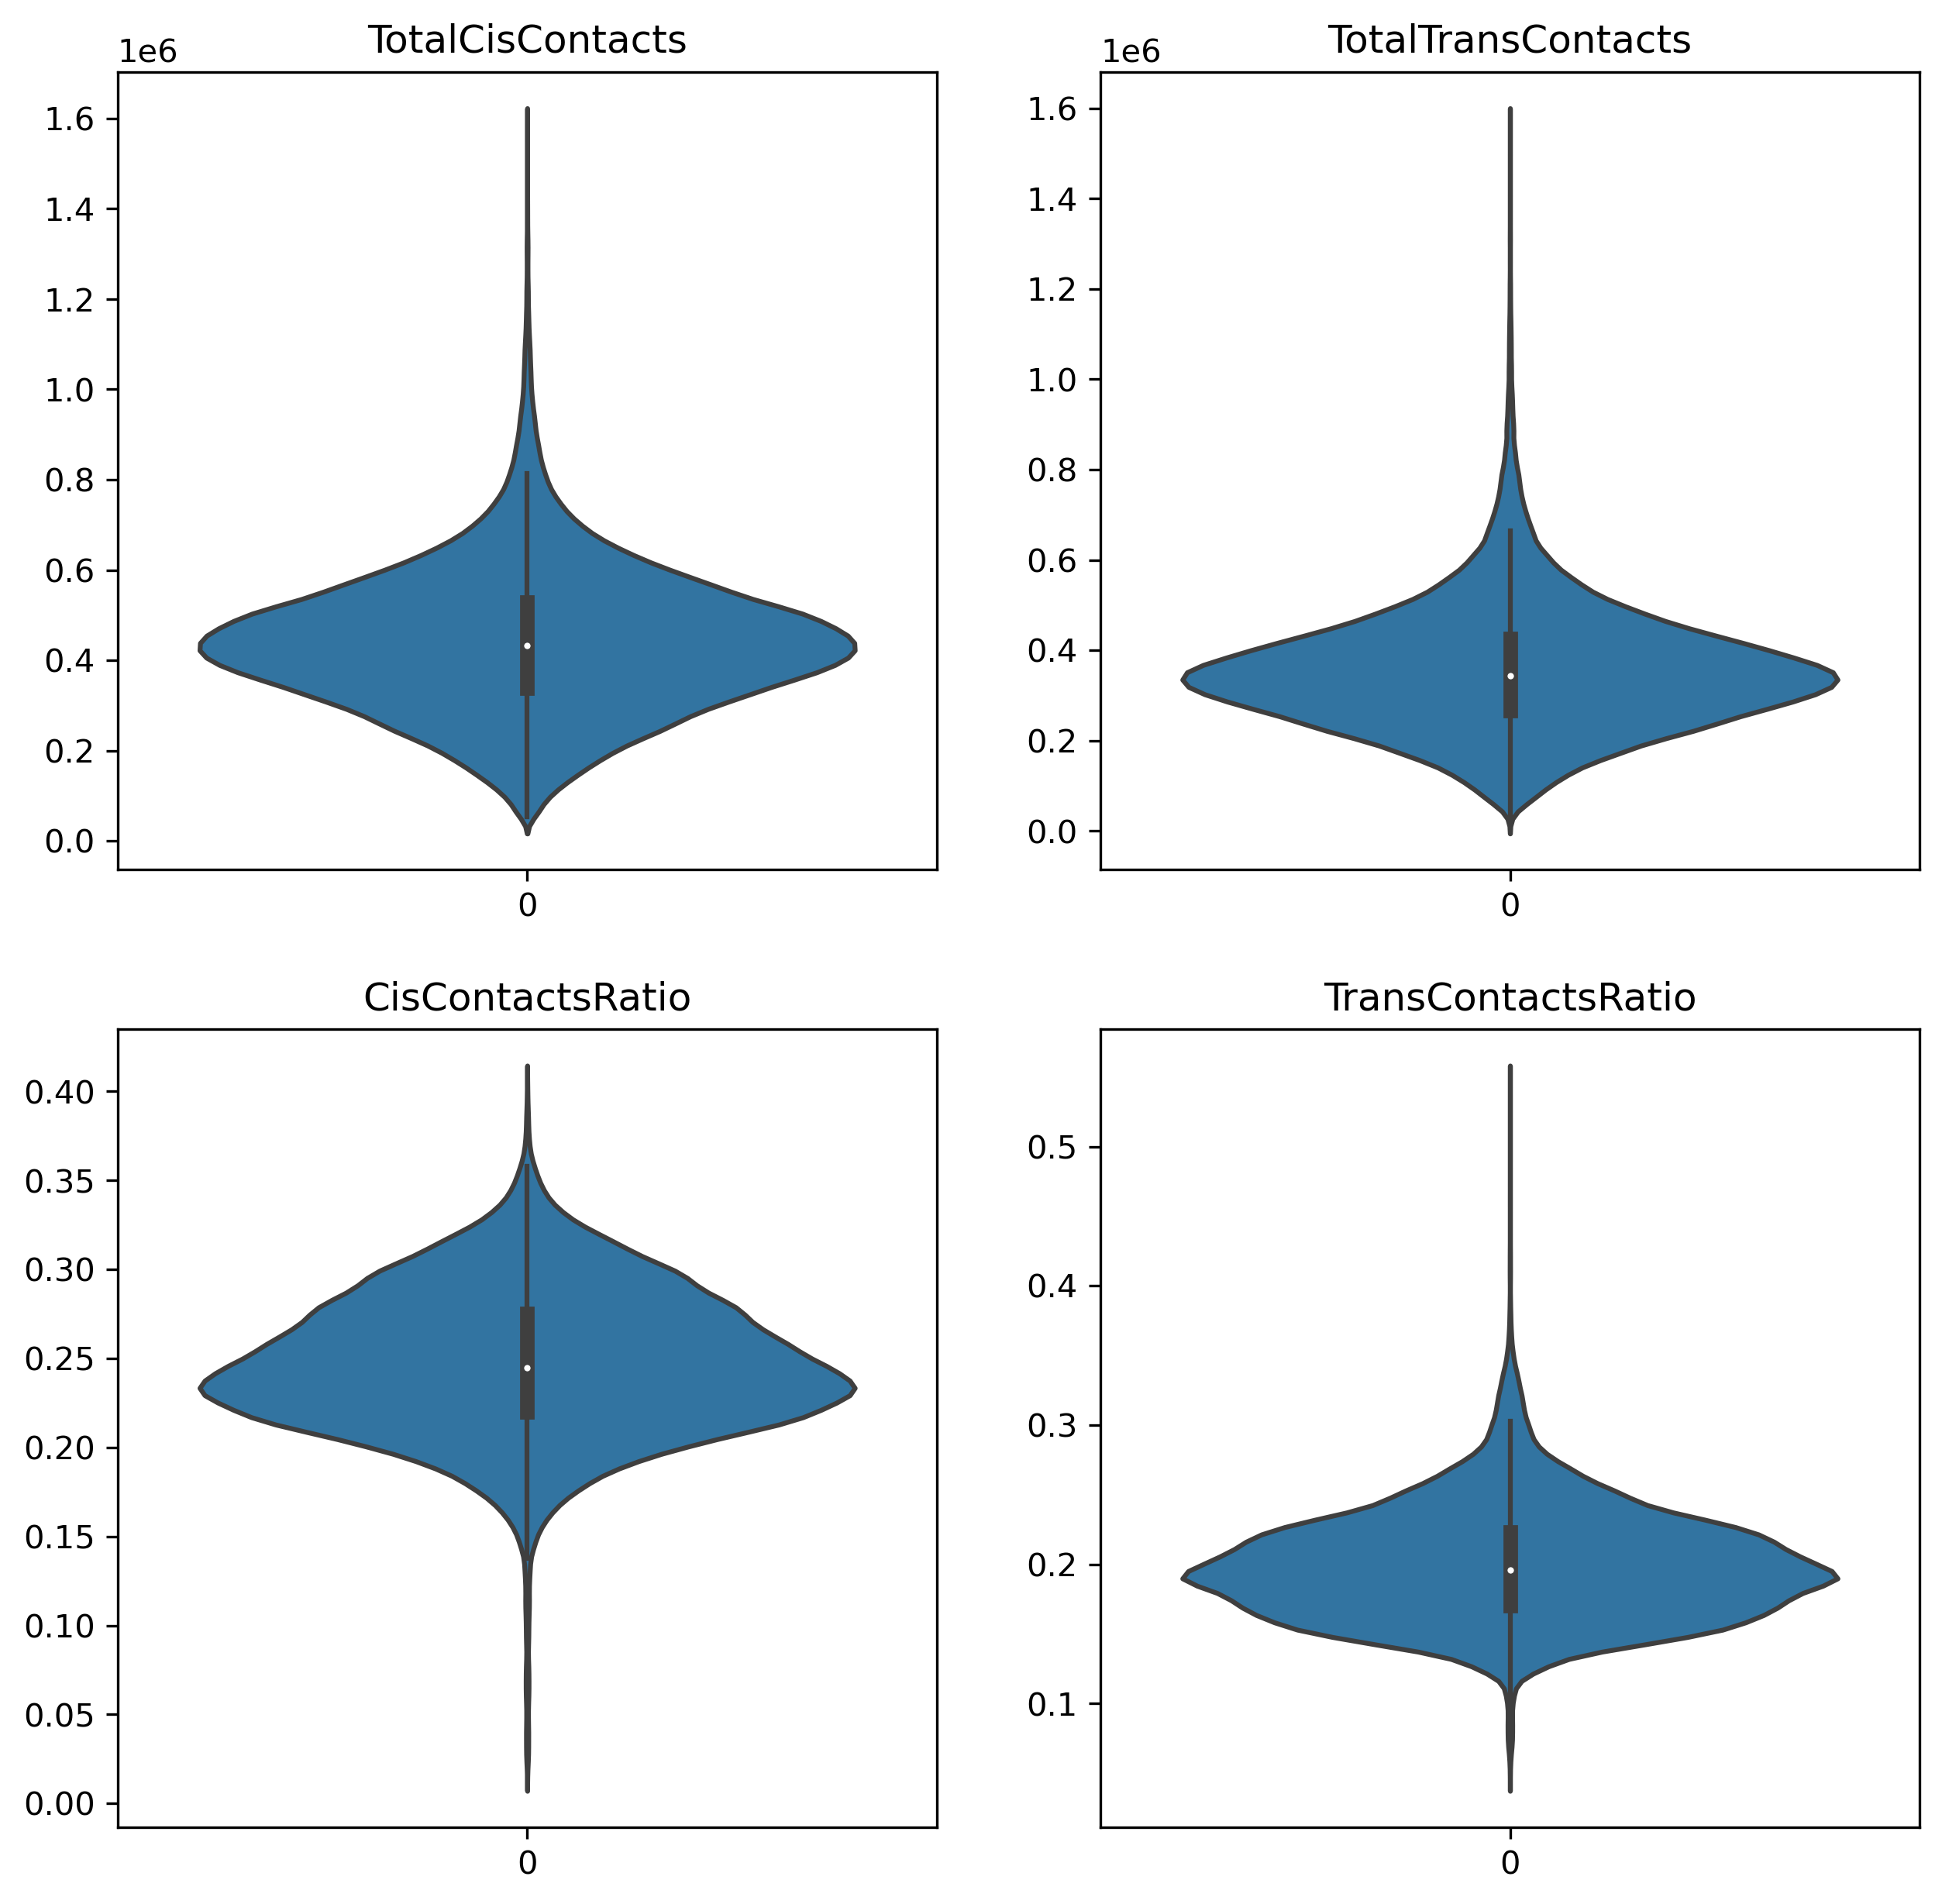

In [18]:
var_list = ['TotalCisContacts', 'TotalTransContacts', 'CisContactsRatio', 'TransContactsRatio']
fig, axes = plt.subplots(figsize=(10, 10), ncols = 2, nrows = 2, dpi=300)

for _var, ax in zip(var_list, axes.ravel()):
    sns.violinplot(m3c_meta[_var], ax=ax)  # Corrected comma placement
    ax.set(title=f'{_var}')
fig.savefig('m3C-contact-violin.pdf')


(0.0, 5000000.0)

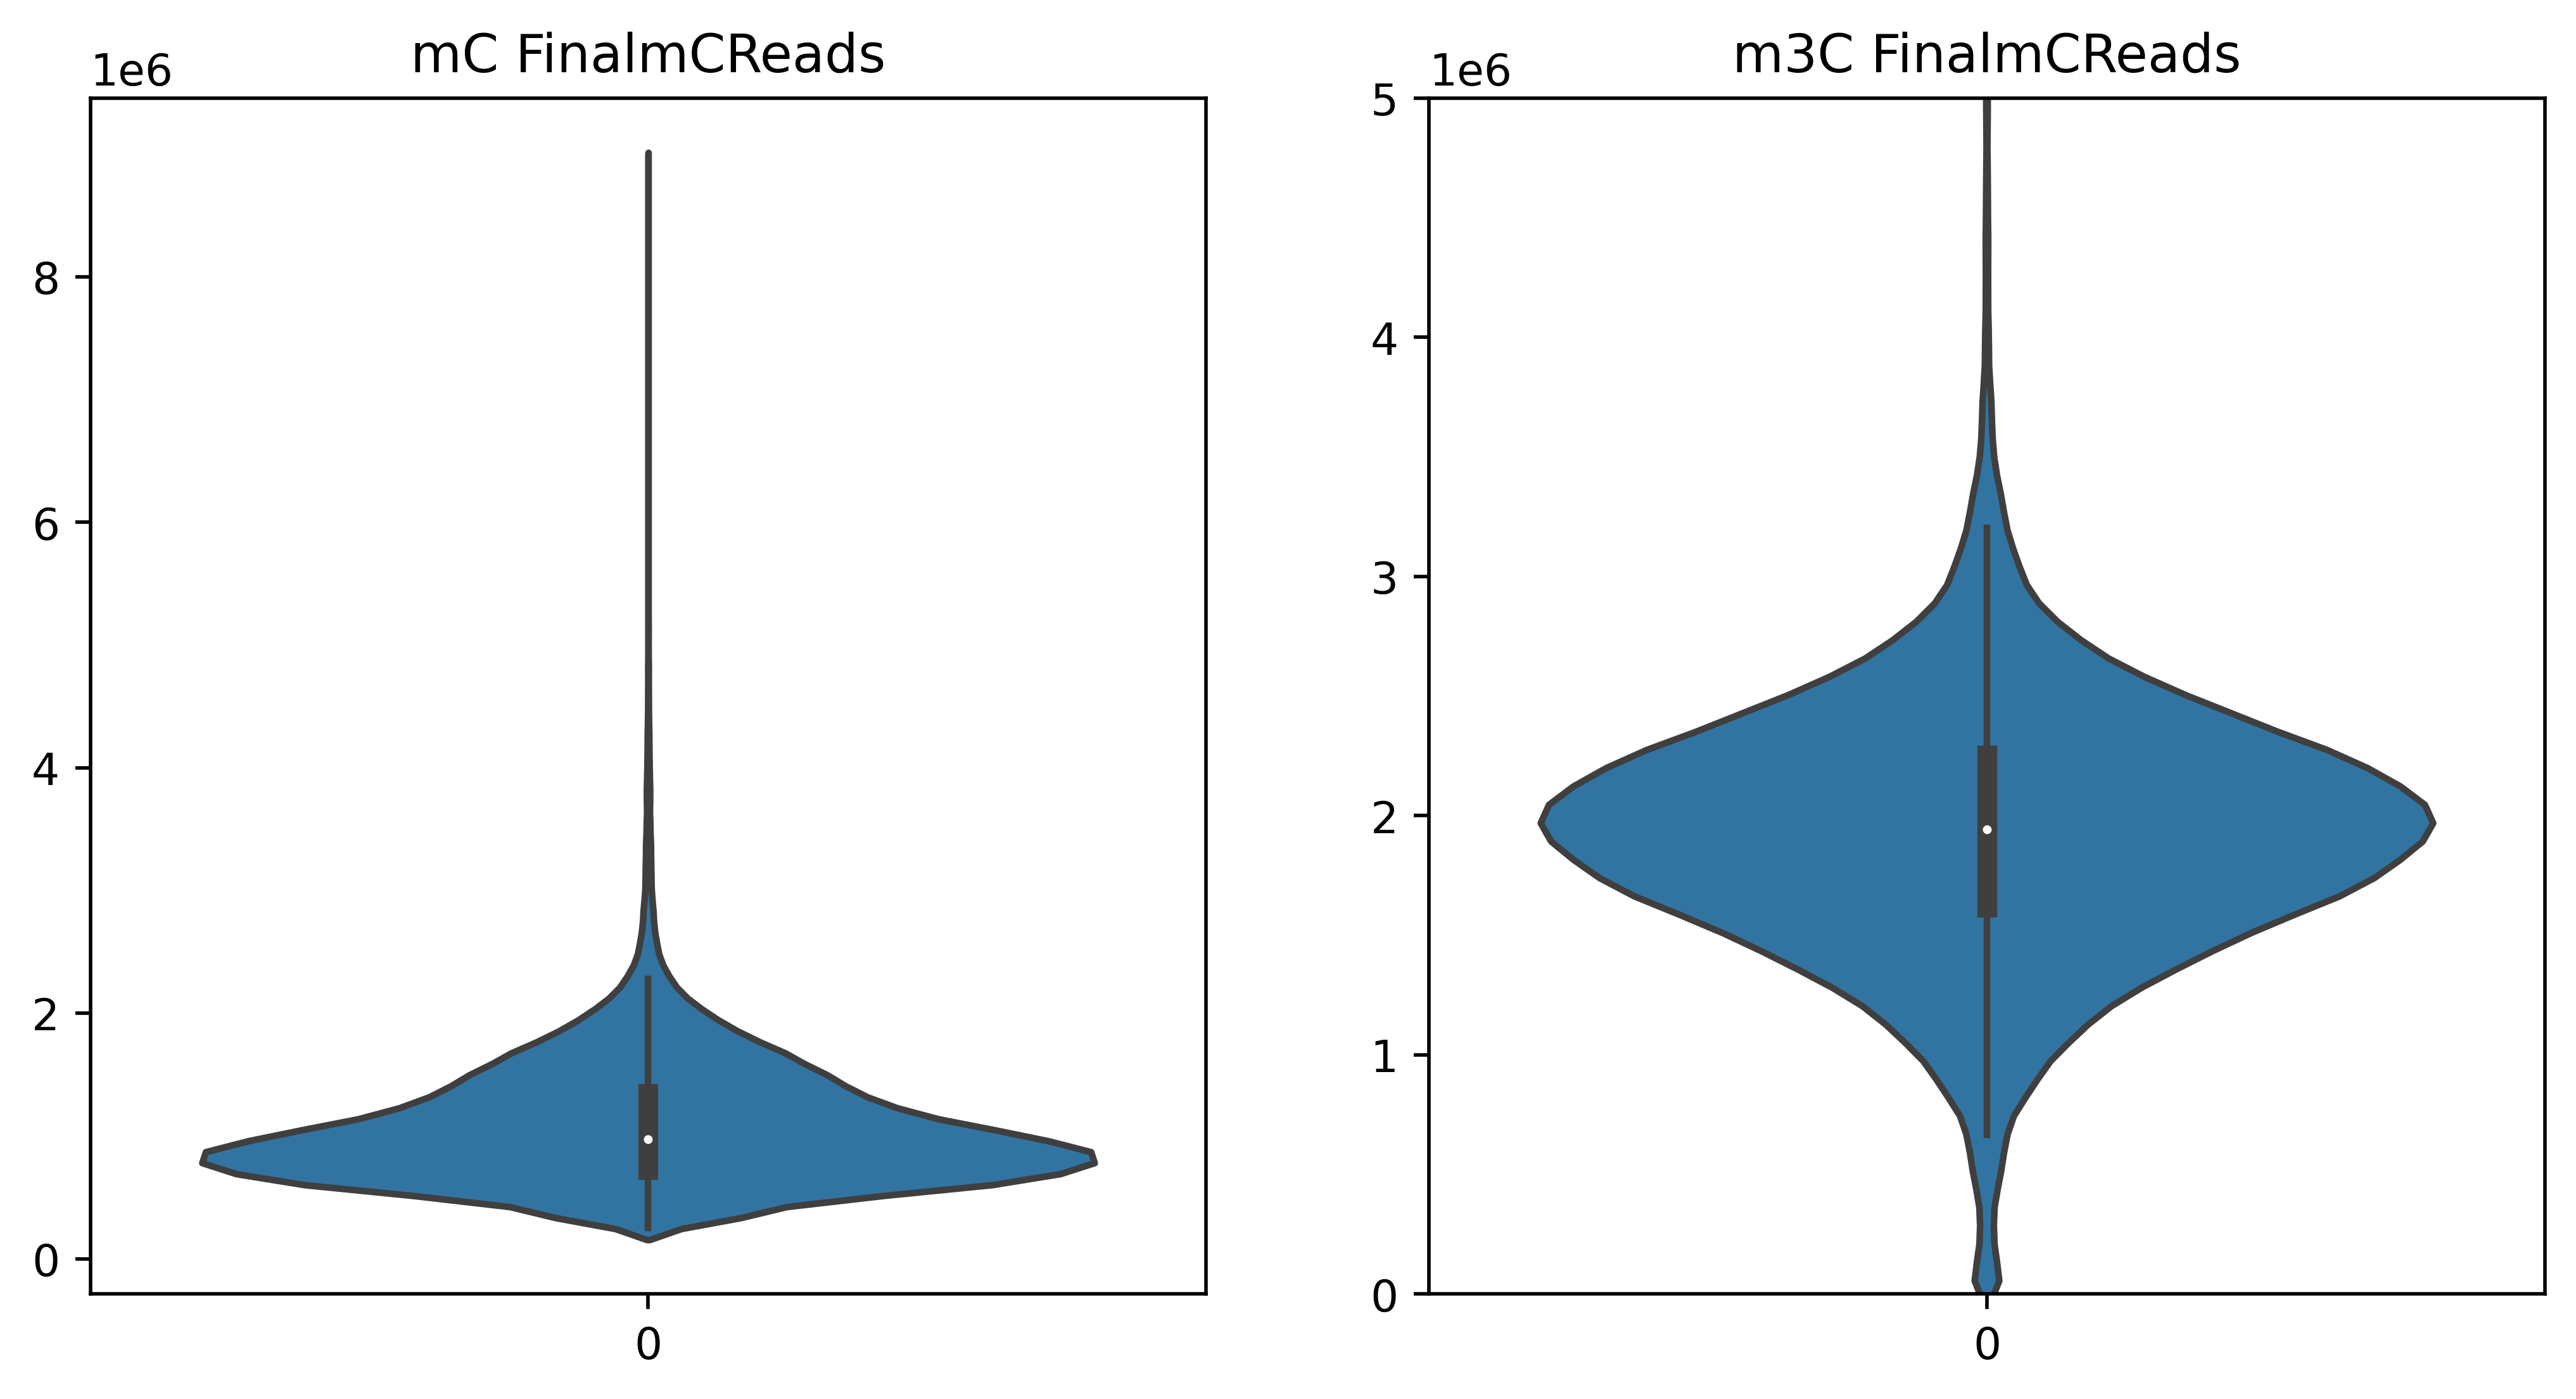

In [13]:
fig, axes = plt.subplots(figsize=(10, 5), ncols = 2, nrows = 1, dpi=500)

ax = axes[0]
sns.violinplot(mc_meta['FinalmCReads'], ax=ax) 
ax.set(title=f'mC FinalmCReads')

ax = axes[1]
sns.violinplot(m3c_meta['UniqueAlignFinalReads'], ax=ax) 
ax.set(title=f'm3C FinalmCReads')
ax.set_ylim(0,5000000)